# DRL Walk-Forward Test

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import yfinance as yf
import random
import os

In [63]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA or CPU: ", device)
print("Device: ",torch.cuda.get_device_name(0))

CUDA or CPU:  cuda
Device:  NVIDIA GeForce RTX 4080


In [64]:
# Experiment parameters
WINDOW_SIZE = 120  # Rolling window size for state representation
STD_WINDOW_SIZE = 20
NUM_ASSETS = 14   # Example number of assets
ENV_STEP_SIZE = 1
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-4
DISCOUNT_FACTOR = 0.9
BATCH_SIZE = 50
EPISODES = 250
THETA = 0.5
SIGMA = 0.02

In [65]:
def calculate_features(data, window_size):
    # Ensure we have enough data for the specified window sizes
    if len(data) < STD_WINDOW_SIZE + window_size:
        raise ValueError("Data length must be at least STD_WINDOW_SIZE + window_size to calculate rolling metrics.")
    
    # Convert data to a tensor and move to GPU
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)

    # Initialize tensors to store results for the rolling metrics
    num_assets = data.shape[1]
    rolling_returns = data_tensor[STD_WINDOW_SIZE:STD_WINDOW_SIZE + window_size]  # Use the returns directly
    rolling_volatilities = torch.zeros((window_size, num_assets), device=device)
    rolling_drawdowns = torch.zeros((window_size, num_assets), device=device)

    # Calculate cumulative returns to determine drawdowns
    cumulative_returns = torch.cumprod(1 + rolling_returns, dim=0)
    peak_values = torch.cummax(cumulative_returns, dim=0).values
    rolling_drawdowns = torch.where(cumulative_returns < peak_values, cumulative_returns - peak_values, torch.tensor(0.0, device=device))

    # Calculate rolling volatilities using an inner window of `std_size`
    for i in range(window_size):
        idx = STD_WINDOW_SIZE + i
        volatility_window = data_tensor[idx - STD_WINDOW_SIZE:idx]  # Only previous `std_size` returns for volatility
        rolling_volatilities[i, :] = volatility_window.std(dim=0)

    # Move results back to CPU if needed
    return (rolling_returns.cpu().numpy(), 
            rolling_volatilities.cpu().numpy(), 
            rolling_drawdowns.cpu().numpy())

In [66]:
def create_state_matrix(returns, volatilities, drawdowns):
    return np.stack([returns, volatilities, drawdowns], axis=0)

In [67]:
class ActorNetwork(nn.Module):
    def __init__(self, num_assets, window_size=WINDOW_SIZE, hidden_dim=256):
        super(ActorNetwork, self).__init__()

        # Define convolutional layers for the primary features (returns, volatilities, drawdowns)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)  # Updated input channels to match
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)  # Increased output channels for more complexity

        # Initialize fully connected layers for feature branch
        self._initialize_feature_branch(num_assets, window_size)

        # Flattened covariance size (num_assets * num_assets)
        self.covariance_size = num_assets * num_assets

        # Define final fully connected layers for combined output
        combined_size = self.feature_output_size + self.covariance_size
        self.fc = nn.Sequential(
            nn.Linear(combined_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_assets),
            nn.Softmax(dim=-1)  # Output portfolio weights
        ).to(device)

    def _initialize_feature_branch(self, num_assets, window_size):
        # Calculate flatten size for the feature branch
        dummy_input = torch.zeros(1, 3, window_size, num_assets).to(device)
        x = torch.relu(self.conv1(dummy_input))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        self.feature_output_size = x.view(1, -1).shape[1]

    def forward(self, state):
        # Process primary features
        features = state['features'].to(device)
        x = torch.relu(self.conv1(features))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(x.size(0), -1)  # Flatten feature branch output

        # Flatten covariance matrix
        covariance = state['covariance'].to(device).view(x.size(0), -1)  # Flatten covariance matrix

        # Combine both branches
        combined = torch.cat([x, covariance], dim=1)

        # Final output layer
        weights = self.fc(combined)
        return weights

In [68]:
class CriticNetwork(nn.Module):
    def __init__(self, num_assets, window_size=WINDOW_SIZE, hidden_dim=256):
        super(CriticNetwork, self).__init__()

        # Convolutional layers for processing the state (features: returns, volatilities, drawdowns)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)  # Updated input channels to match conv3
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)  # Increased output channels for more complexity

        # Initialize fully connected layers for the feature branch
        self._initialize_feature_branch(num_assets, window_size)

        # Flattened covariance size (num_assets * num_assets)
        self.covariance_size = num_assets * num_assets

        # Fully connected layers for action processing
        self.fc_action = nn.Sequential(
            nn.Linear(num_assets, hidden_dim),
            nn.ReLU()
        ).to(device)

        # Final layers for combining all representations (features, covariance, action)
        combined_size = self.feature_output_size + self.covariance_size + hidden_dim
        self.fc_q = nn.Sequential(
            nn.Linear(combined_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Output Q-value
        ).to(device)

    def _initialize_feature_branch(self, num_assets, window_size):
        # Calculate flatten size for the feature branch
        dummy_input = torch.zeros(1, 3, window_size, num_assets).to(device)
        x = torch.relu(self.conv1(dummy_input))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        self.feature_output_size = x.view(1, -1).shape[1]

    def forward(self, state, action):
        # Process the state (features: returns, volatilities, drawdowns)
        features = state['features'].to(device)
        x = torch.relu(self.conv1(features))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(x.size(0), -1)  # Flatten feature branch output
        state_out = x

        # Flatten covariance matrix
        covariance = state['covariance'].to(device).view(x.size(0), -1)  # Flatten covariance matrix
        cov_out = covariance

        # Process the action
        action_out = self.fc_action(action.to(device))

        # Combine all branches
        combined = torch.cat([state_out, cov_out, action_out], dim=1)

        # Compute Q-value
        q_value = self.fc_q(combined)
        return q_value

In [69]:
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """
        Ornstein-Uhlenbeck noise process.
        Args:
            size (int): Dimension of the noise.
            mu (float): Mean of the process.
            theta (float): Speed of mean reversion.
            sigma (float): Volatility parameter.
        """
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def reset(self):
        """Reset the internal state to the mean."""
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        """Generate a noise sample."""
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.normal(size=self.size)
        self.state += dx
        return self.state

In [70]:
class DDPGAgent:
    def __init__(self, num_assets):
        # Initialize actor and critic networks, and target networks
        self.actor = ActorNetwork(num_assets).to(device)
        self.critic = CriticNetwork(num_assets).to(device)
        self.target_actor = ActorNetwork(num_assets).to(device)
        self.target_critic = CriticNetwork(num_assets).to(device)

        # Synchronize target networks with the main networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        # Replay memory
        self.memory = deque(maxlen=10000)
        self.batch_size = BATCH_SIZE
        self.discount_factor = DISCOUNT_FACTOR
        self.tau = 0.005  # Soft update rate for target networks

        # OU Noise for exploration
        self.ou_noise = OUNoise(size=num_assets, theta=THETA, sigma=SIGMA)

    def act(self, state, add_noise=True):
        """
        Get an action from the actor network, optionally adding noise.
        Args:
            state (np.array): Current state.
            add_noise (bool): Whether to add exploration noise.
        Returns:
            np.array: Action vector.
        """
        # Convert state components to tensors and move to GPU if available
        features_tensor = torch.tensor(state['features'], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 3, WINDOW_SIZE, NUM_ASSETS)
        covariance_tensor = torch.tensor(state['covariance'], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 1, NUM_ASSETS, NUM_ASSETS)

        # Combine tensors into a dictionary to match the actor's expected input
        state_tensor = {
            'features': features_tensor,
            'covariance': covariance_tensor
        }

        # Pass the structured state to the actor and get the action
        action = self.actor(state_tensor).detach().cpu().numpy()[0]  # Move action back to CPU

        # Optionally add Ornstein-Uhlenbeck noise for exploration
        if add_noise:
            noise = self.ou_noise.sample()
            action += noise

        action = np.clip(action, 0, 1)  # Ensure valid portfolio weights 
        return action / action.sum()  # Ensure weights sum to 1

    def reset_noise(self):
        """Reset the Ornstein-Uhlenbeck noise process."""
        self.ou_noise.reset()

    def update(self):
        # Check if there are enough samples in memory
        if len(self.memory) < self.batch_size:
            return

        # Sample a mini-batch of experiences from the replay buffer
        mini_batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # Convert rewards and dones to tensors
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).view(-1, 1).to(device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32).view(-1, 1).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.float32).to(device)

        # Process states and next_states into features and covariance components
        states_features = torch.tensor(np.array([s['features'] for s in states]), dtype=torch.float32).to(device)
        states_covariance = torch.tensor(np.array([s['covariance'] for s in states]), dtype=torch.float32).unsqueeze(1).to(device)

        next_states_features = torch.tensor(np.array([s['features'] for s in next_states]), dtype=torch.float32).to(device)
        next_states_covariance = torch.tensor(np.array([s['covariance'] for s in next_states]), dtype=torch.float32).unsqueeze(1).to(device)

        # Create structured state dictionaries for compatibility with the networks
        states_dict = {'features': states_features, 'covariance': states_covariance}
        next_states_dict = {'features': next_states_features, 'covariance': next_states_covariance}

        # Critic update
        with torch.no_grad():
            next_actions = self.target_actor(next_states_dict)
            target_q_values = self.target_critic(next_states_dict, next_actions)
            target_values = rewards + self.discount_factor * target_q_values * (1 - dones)

        current_q_values = self.critic(states_dict, actions)
        critic_loss = nn.MSELoss()(current_q_values, target_values)

        # Backpropagate the loss for the critic network
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        # Actor update
        predicted_actions = self.actor(states_dict)
        actor_loss = -self.critic(states_dict, predicted_actions).mean()  # Maximize Q-value
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        # Soft update for target networks
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [71]:
# Define tickers
tickers = {
    'XLF': 'XLF',   # Financials Select Sector SPDR Fund
    'XLK': 'XLK',   # Technology Select Sector SPDR Fund
    'XLE': 'XLE',   # Energy Select Sector SPDR Fund
    'XLP': 'XLP',   # Consumer Staples Select Sector SPDR Fund
    'XLY': 'XLY',   # Consumer Discretionary Select Sector SPDR Fund
    'XLU': 'XLU',   # Utilities Select Sector SPDR Fund
    'XLI': 'XLI',   # Industrials Select Sector SPDR Fund
    'XLV': 'XLV',   # Health Care Select Sector SPDR Fund
    'VNQ': 'VNQ',   # Vanguard Real Estate ETF
    'IYZ': 'IYZ',   # iShares U.S. Telecommunications ETF
    'XBI': 'XBI',   # SPDR S&P Biotech ETF
    'XOP': 'XOP',   # SPDR S&P Oil & Gas Exploration ETF
    'ITA': 'ITA',   # iShares U.S. Aerospace & Defense ETF
    'KBE': 'KBE'    # SPDR S&P Bank ETF
}

# Define the range of years
start_year = 2016
end_year = 2023

# Initialize an empty list to store filtered returns
filtered_returns_list = []

# Loop through each year in the range
for year in range(start_year, end_year + 1):
    # Define the analysis and extra data start dates
    start_analysis_date = f"{year}-01-01"
    extra_data_start_date = f"{year - 1}-01-01"
    end_date = f"{year}-12-31"

    # Download data
    data = yf.download(list(tickers.values()), start=extra_data_start_date, end=end_date)['Adj Close']

    # Calculate daily returns
    returns = data.pct_change().dropna()

    # Print data summary
    print(f"\n--- Year: {year} ---")
    print("Data Start Date:", returns.index.min())
    print("Data End Date:", returns.index.max())
    print("Total Days in Dataset:", len(returns))

    # Convert start_analysis_date to pandas Timestamp
    start_analysis_date = pd.Timestamp(start_analysis_date)

    # Ensure the index is timezone-naive for consistency
    returns.index = returns.index.tz_localize(None)

    # Find the index of the closest date before or equal to the start_analysis_date
    if start_analysis_date not in returns.index:
        start_analysis_date = returns.index.asof(start_analysis_date)

    analysis_index = returns.index.get_loc(start_analysis_date)

    # Compute the index for the look-back start date
    lookback_start_index = analysis_index - (WINDOW_SIZE + STD_WINDOW_SIZE)

    # Validate the computed index
    if lookback_start_index < 0:
        print("Warning: Not enough data available for the look-back period!")
        continue

    print("Lookback Start Index:", lookback_start_index)
    print("Analysis Index:", analysis_index)

    # Get the look-back start date from the index
    lookback_start_date = returns.index[lookback_start_index]

    # Filter the data to include the necessary look-back period
    filtered_returns = returns.loc[lookback_start_date:]
    filtered_returns_list.append(filtered_returns)

    # Confirm the filtered data range
    print(f"Filtered Data Start Date (includes look-back): {filtered_returns.index.min()}")
    print(f"Filtered Data End Date: {filtered_returns.index.max()}")

# Output the number of processed periods
print(f"\nTotal periods processed: {len(filtered_returns_list)}")

[*********************100%***********************]  14 of 14 completed
[**********************64%******                 ]  9 of 14 completed


--- Year: 2016 ---
Data Start Date: 2015-01-05 00:00:00+00:00
Data End Date: 2016-12-30 00:00:00+00:00
Total Days in Dataset: 503
Lookback Start Index: 110
Analysis Index: 250
Filtered Data Start Date (includes look-back): 2015-06-12 00:00:00
Filtered Data End Date: 2016-12-30 00:00:00


[*********************100%***********************]  14 of 14 completed
[**********************57%**                     ]  8 of 14 completed


--- Year: 2017 ---
Data Start Date: 2016-01-05 00:00:00+00:00
Data End Date: 2017-12-29 00:00:00+00:00
Total Days in Dataset: 502
Lookback Start Index: 110
Analysis Index: 250
Filtered Data Start Date (includes look-back): 2016-06-13 00:00:00
Filtered Data End Date: 2017-12-29 00:00:00


[*********************100%***********************]  14 of 14 completed
[**********************64%******                 ]  9 of 14 completed


--- Year: 2018 ---
Data Start Date: 2017-01-04 00:00:00+00:00
Data End Date: 2018-12-28 00:00:00+00:00
Total Days in Dataset: 500
Lookback Start Index: 109
Analysis Index: 249
Filtered Data Start Date (includes look-back): 2017-06-12 00:00:00
Filtered Data End Date: 2018-12-28 00:00:00


[*********************100%***********************]  14 of 14 completed
[**********************50%                       ]  7 of 14 completed


--- Year: 2019 ---
Data Start Date: 2018-01-03 00:00:00+00:00
Data End Date: 2019-12-30 00:00:00+00:00
Total Days in Dataset: 501
Lookback Start Index: 109
Analysis Index: 249
Filtered Data Start Date (includes look-back): 2018-06-11 00:00:00
Filtered Data End Date: 2019-12-30 00:00:00


[*********************100%***********************]  14 of 14 completed
[**********************64%******                 ]  9 of 14 completed


--- Year: 2020 ---
Data Start Date: 2019-01-03 00:00:00+00:00
Data End Date: 2020-12-30 00:00:00+00:00
Total Days in Dataset: 503
Lookback Start Index: 110
Analysis Index: 250
Filtered Data Start Date (includes look-back): 2019-06-12 00:00:00
Filtered Data End Date: 2020-12-30 00:00:00


[*********************100%***********************]  14 of 14 completed
[**********************64%******                 ]  9 of 14 completed


--- Year: 2021 ---
Data Start Date: 2020-01-03 00:00:00+00:00
Data End Date: 2021-12-30 00:00:00+00:00
Total Days in Dataset: 503
Lookback Start Index: 111
Analysis Index: 251
Filtered Data Start Date (includes look-back): 2020-06-12 00:00:00
Filtered Data End Date: 2021-12-30 00:00:00


[*********************100%***********************]  14 of 14 completed
[**********************64%******                 ]  9 of 14 completed


--- Year: 2022 ---
Data Start Date: 2021-01-05 00:00:00+00:00
Data End Date: 2022-12-30 00:00:00+00:00
Total Days in Dataset: 502
Lookback Start Index: 110
Analysis Index: 250
Filtered Data Start Date (includes look-back): 2021-06-14 00:00:00
Filtered Data End Date: 2022-12-30 00:00:00


[*********************100%***********************]  14 of 14 completed


--- Year: 2023 ---
Data Start Date: 2022-01-04 00:00:00+00:00
Data End Date: 2023-12-29 00:00:00+00:00
Total Days in Dataset: 500
Lookback Start Index: 109
Analysis Index: 249
Filtered Data Start Date (includes look-back): 2022-06-10 00:00:00
Filtered Data End Date: 2023-12-29 00:00:00

Total periods processed: 8


In [72]:
def calculate_max_drawdown(returns):
    """
    Calculate the maximum drawdown from a series of returns.
    Handles potential numerical issues and invalid values.
    Args:
        returns (array-like): Daily or periodic returns of a portfolio.
    Returns:
        max_drawdown (float): Maximum drawdown (as a positive number).
    """
    # Ensure returns are a numpy array
    returns = np.array(returns)
    
    # Remove invalid values
    returns = returns[np.isfinite(returns)]

    # Handle edge case: if no valid returns, return NaN
    if len(returns) == 0:
        return np.nan

    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + returns)

    # Clip cumulative returns to avoid numerical overflow
    cumulative_returns = np.clip(cumulative_returns, a_min=1e-10, a_max=1e10)

    # Calculate the running peak
    peak = np.maximum.accumulate(cumulative_returns)

    # Calculate drawdown
    drawdown = (cumulative_returns - peak) / peak

    # Calculate maximum drawdown (most negative drawdown value)
    max_drawdown = np.min(drawdown)

    # Return the absolute value of the maximum drawdown
    return abs(max_drawdown)

## "Best" Model

In [73]:
# Create the stats directory if it does not exist
stats_dir = "stats"
os.makedirs(stats_dir, exist_ok=True)

# Initialize lists to store portfolio returns and weight history for each period
all_portfolio_returns = {}
all_weight_history = {}

# Loop through each period in `filtered_returns_list`
for i in range(len(filtered_returns_list)):
    print(f"\n--- Testing for Period {i + 1} ---")

    # Instantiate the agent
    agent = DDPGAgent(num_assets=NUM_ASSETS)

    # Load the trained model for the current period
    actor_path = f"saved_models/best_actor_7-{i+2}.pth"
    critic_path = f"saved_models/best_critic_7-{i+2}.pth"
    if os.path.exists(actor_path) and os.path.exists(critic_path):
        agent.actor.load_state_dict(torch.load(actor_path))
        agent.actor.eval()  # Set the actor to evaluation mode
        print(f"Loaded actor model from {actor_path}")
    else:
        raise FileNotFoundError(f"Missing required models: {actor_path} or {critic_path}")

    # Set the rebalancing period
    rebalance_period = 20

    # Lists to store the daily portfolio returns and weight history for the current period
    portfolio_returns = []
    weight_history = []

    # Initialize state for the first rebalancing period
    state = None
    weights = None  # Portfolio weights allocated by the agent

    print(range(STD_WINDOW_SIZE + WINDOW_SIZE, len(filtered_returns_list[i])))

    # Testing loop
    for j in range(STD_WINDOW_SIZE + WINDOW_SIZE, len(filtered_returns_list[i])):
        # Every `rebalance_period` days, use the agent to determine new weights
        if j % rebalance_period == 0:
            # Get the current state from the environment
            window_data = filtered_returns_list[i].iloc[j - STD_WINDOW_SIZE - WINDOW_SIZE:j]
            returns, volatilities, drawdowns = calculate_features(window_data, WINDOW_SIZE)
            state = create_state_matrix(returns, volatilities, drawdowns)

            # Calculate the rolling covariance matrix
            cov = filtered_returns_list[i].iloc[j - WINDOW_SIZE:j].cov()

            # Store the covariance matrix as part of the state
            state = {
                'features': state,  # Original features (returns, volatilities, drawdowns)
                'covariance': cov.values  # Covariance matrix
            }

            # Get portfolio weights from the agent
            with torch.no_grad():
                weights = agent.act(state, add_noise=False)  # No exploration noise during testing
                weights = np.clip(weights, 0, 1)  # Clip weights to ensure they are within bounds
                weights /= weights.sum()  # Normalize to ensure they sum to 1

            # Store the current weights in the weight history
            weight_history.append(weights)

        # Calculate portfolio return for the day based on the fixed weights
        daily_portfolio_return = np.dot(weights, filtered_returns_list[i].iloc[j].values)
        portfolio_returns.append(daily_portfolio_return)

    # Store results for this period
    all_portfolio_returns[i + 1] = np.array(portfolio_returns)
    all_weight_history[i + 1] = np.array(weight_history)

    # Save the portfolio returns and weight history to the stats folder
    np.save(os.path.join(stats_dir, f"best_portfolio_returns_7-{i + 2}.npy"), all_portfolio_returns[i + 1])
    np.save(os.path.join(stats_dir, f"best_weight_history_7-{i + 2}.npy"), all_weight_history[i + 1])

    # Print the shape of the weight history for verification
    print(f"Weight History Shape for Period {i + 1}: {all_weight_history[i + 1].shape}")



--- Testing for Period 1 ---
Loaded actor model from saved_models/best_actor_7-2.pth
range(140, 393)
Weight History Shape for Period 1: (13, 14)

--- Testing for Period 2 ---
Loaded actor model from saved_models/best_actor_7-3.pth
range(140, 392)
Weight History Shape for Period 2: (13, 14)

--- Testing for Period 3 ---
Loaded actor model from saved_models/best_actor_7-4.pth
range(140, 391)
Weight History Shape for Period 3: (13, 14)

--- Testing for Period 4 ---
Loaded actor model from saved_models/best_actor_7-5.pth
range(140, 392)
Weight History Shape for Period 4: (13, 14)

--- Testing for Period 5 ---
Loaded actor model from saved_models/best_actor_7-6.pth
range(140, 393)
Weight History Shape for Period 5: (13, 14)

--- Testing for Period 6 ---
Loaded actor model from saved_models/best_actor_7-7.pth
range(140, 392)
Weight History Shape for Period 6: (13, 14)

--- Testing for Period 7 ---
Loaded actor model from saved_models/best_actor_7-8.pth
range(140, 392)
Weight History Shape f

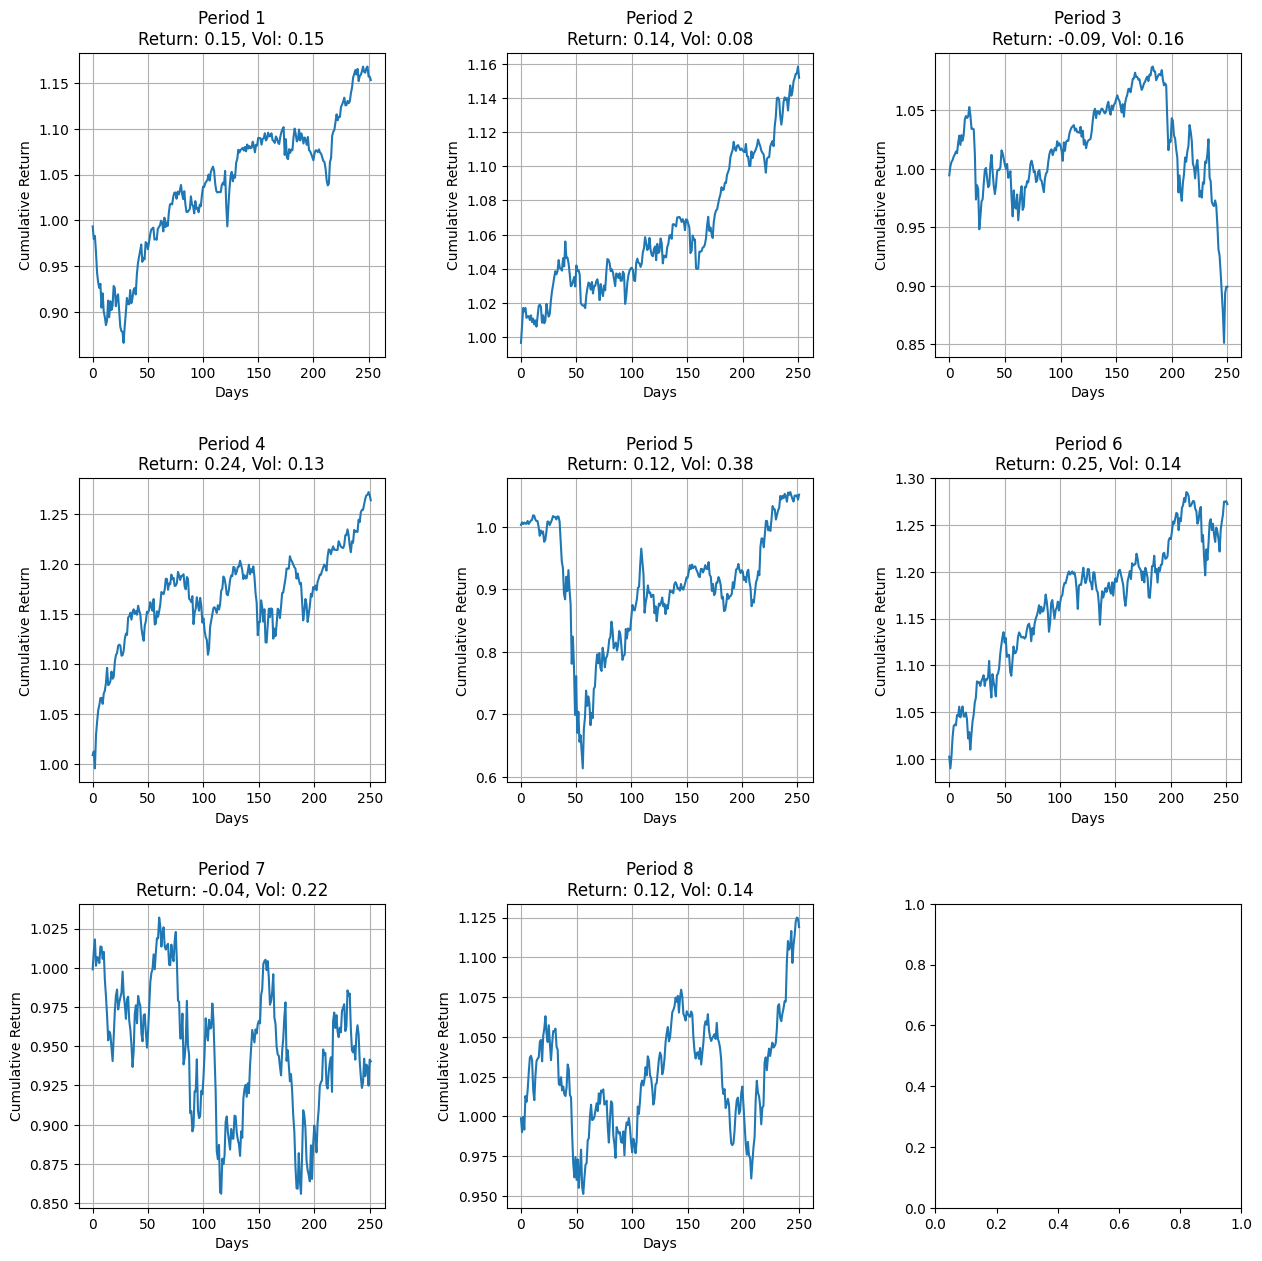

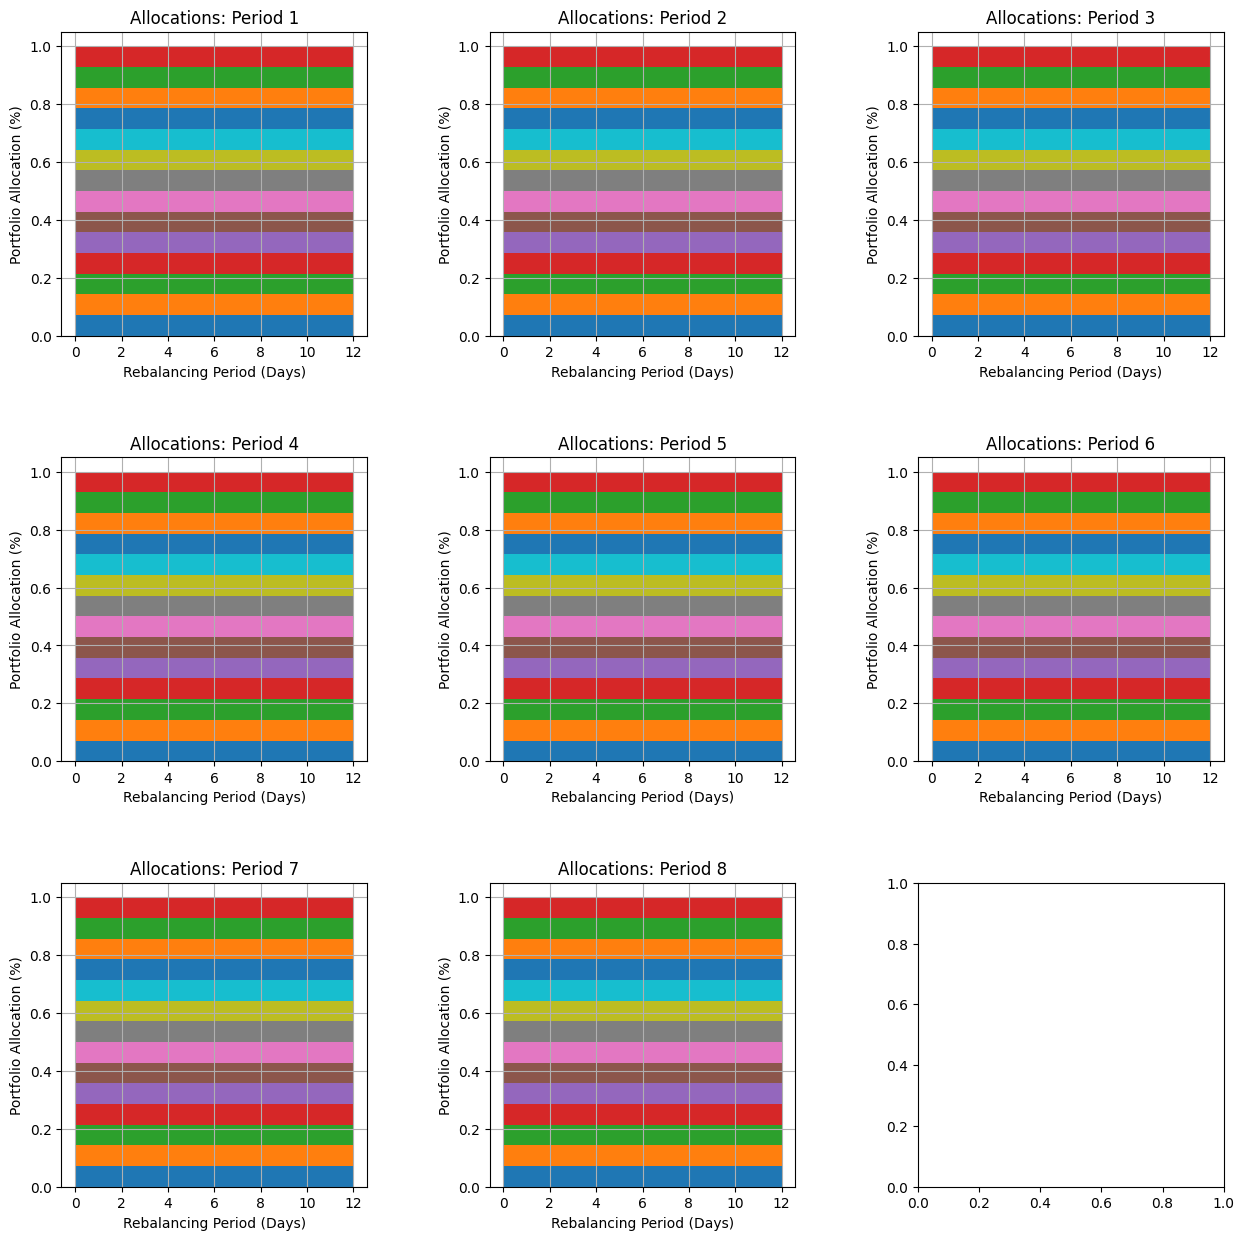


--- Portfolio Statistics for Each Period ---
Period: 1
  Annualized Return: 0.1532
  Annualized Volatility: 0.1501
  Sharpe Ratio: 1.0205
  Max Drawdown: 0.1278
  Calmar Ratio: 1.1988
--------------------------------------------------
Period: 2
  Annualized Return: 0.1442
  Annualized Volatility: 0.0760
  Sharpe Ratio: 1.8959
  Max Drawdown: 0.0369
  Calmar Ratio: 3.9081
--------------------------------------------------
Period: 3
  Annualized Return: -0.0938
  Annualized Volatility: 0.1601
  Sharpe Ratio: -0.5856
  Max Drawdown: 0.2170
  Calmar Ratio: -0.4321
--------------------------------------------------
Period: 4
  Annualized Return: 0.2422
  Annualized Volatility: 0.1270
  Sharpe Ratio: 1.9065
  Max Drawdown: 0.0694
  Calmar Ratio: 3.4907
--------------------------------------------------
Period: 5
  Annualized Return: 0.1238
  Annualized Volatility: 0.3811
  Sharpe Ratio: 0.3247
  Max Drawdown: 0.3979
  Calmar Ratio: 0.3110
--------------------------------------------------
P

In [74]:
# Analysis and Visualization

# Define the number of trading days per year
trading_days_per_year = 252

# Initialize lists to store statistics
all_stats = []

# Initialize a figure for the 3x3 grid layout
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through each period for analysis
for idx, (period, returns) in enumerate(all_portfolio_returns.items()):
    # Skip extra axes if there are fewer periods than 9
    if idx >= 9:
        break

    # Calculate cumulative returns
    cumulative_return = np.cumprod(1 + returns)

    # Calculate annualized return
    annualized_return = np.mean(returns) * trading_days_per_year

    # Calculate annualized volatility
    annualized_volatility = np.std(returns) * np.sqrt(trading_days_per_year)

    # Calculate Sharpe ratio (assuming a risk-free rate of 0 for simplicity)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

    # Calculate the max drawdown
    max_drawdown = calculate_max_drawdown(returns)

    # Calculate Calmar ratio (handle divide by zero)
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.nan

    # Store stats in a list
    all_stats.append({
        "Period": period,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    })

    # Plot cumulative portfolio returns in the top row
    axes[idx].plot(cumulative_return)
    axes[idx].set_title(f"Period {period}\nReturn: {annualized_return:.2f}, Vol: {annualized_volatility:.2f}")
    axes[idx].set_xlabel("Days")
    axes[idx].set_ylabel("Cumulative Return")
    axes[idx].grid()

# Create a new figure for stacked area plots
fig_alloc, axes_alloc = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
fig_alloc.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots

# Flatten axes array for easy indexing
axes_alloc = axes_alloc.flatten()

# Loop through each period for allocation plots
for idx, (period, weight_history) in enumerate(all_weight_history.items()):
    # Skip extra axes if there are fewer periods than 9
    if idx >= 9:
        break

    num_rebalancing_periods, num_assets = weight_history.shape

    # Stacked area plot for portfolio allocations
    axes_alloc[idx].stackplot(range(num_rebalancing_periods), weight_history.T)
    axes_alloc[idx].set_title(f"Allocations: Period {period}")
    axes_alloc[idx].set_xlabel("Rebalancing Period (Days)")
    axes_alloc[idx].set_ylabel("Portfolio Allocation (%)")
    axes_alloc[idx].grid()

# Show both figures
plt.show()

# Print all statistics
print("\n--- Portfolio Statistics for Each Period ---")
for stats in all_stats:
    print(f"Period: {stats['Period']}")
    print(f"  Annualized Return: {stats['Annualized Return']:.4f}")
    print(f"  Annualized Volatility: {stats['Annualized Volatility']:.4f}")
    print(f"  Sharpe Ratio: {stats['Sharpe Ratio']:.4f}")
    print(f"  Max Drawdown: {stats['Max Drawdown']:.4f}")
    print(f"  Calmar Ratio: {stats['Calmar Ratio']:.4f}")
    print("-" * 50)


## Last Model

In [75]:
# Create the stats directory if it does not exist
stats_dir = "stats"
os.makedirs(stats_dir, exist_ok=True)

# Initialize lists to store portfolio returns and weight history for each period
all_portfolio_returns = {}
all_weight_history = {}

# Loop through each period in `filtered_returns_list`
for i in range(len(filtered_returns_list)):
    print(f"\n--- Testing for Period {i + 1} ---")

    # Instantiate the agent
    agent = DDPGAgent(num_assets=NUM_ASSETS)

    # Load the trained model for the current period
    actor_path = f"saved_models/best_actor_7-{i+2}.pth"
    critic_path = f"saved_models/best_critic_7-{i+2}.pth"
    if os.path.exists(actor_path) and os.path.exists(critic_path):
        agent.actor.load_state_dict(torch.load(actor_path))
        agent.actor.eval()  # Set the actor to evaluation mode
        print(f"Loaded actor model from {actor_path}")
    else:
        raise FileNotFoundError(f"Missing required models: {actor_path} or {critic_path}")

    # Set the rebalancing period
    rebalance_period = 20

    # Lists to store the daily portfolio returns and weight history for the current period
    portfolio_returns = []
    weight_history = []

    # Initialize state for the first rebalancing period
    state = None
    weights = None  # Portfolio weights allocated by the agent

    print(range(STD_WINDOW_SIZE + WINDOW_SIZE, len(filtered_returns_list[i])))

    # Testing loop
    for j in range(STD_WINDOW_SIZE + WINDOW_SIZE, len(filtered_returns_list[i])):
        # Every `rebalance_period` days, use the agent to determine new weights
        if j % rebalance_period == 0:
            # Get the current state from the environment
            window_data = filtered_returns_list[i].iloc[j - STD_WINDOW_SIZE - WINDOW_SIZE:j]
            returns, volatilities, drawdowns = calculate_features(window_data, WINDOW_SIZE)
            state = create_state_matrix(returns, volatilities, drawdowns)

            # Calculate the rolling covariance matrix
            cov = filtered_returns_list[i].iloc[j - WINDOW_SIZE:j].cov()

            # Store the covariance matrix as part of the state
            state = {
                'features': state,  # Original features (returns, volatilities, drawdowns)
                'covariance': cov.values  # Covariance matrix
            }

            # Get portfolio weights from the agent
            with torch.no_grad():
                weights = agent.act(state, add_noise=False)  # No exploration noise during testing
                weights = np.clip(weights, 0, 1)  # Clip weights to ensure they are within bounds
                weights /= weights.sum()  # Normalize to ensure they sum to 1

            # Store the current weights in the weight history
            weight_history.append(weights)

        # Calculate portfolio return for the day based on the fixed weights
        daily_portfolio_return = np.dot(weights, filtered_returns_list[i].iloc[j].values)
        portfolio_returns.append(daily_portfolio_return)

    # Store results for this period
    all_portfolio_returns[i + 1] = np.array(portfolio_returns)
    all_weight_history[i + 1] = np.array(weight_history)

    # Save the portfolio returns and weight history to the stats folder
    np.save(os.path.join(stats_dir, f"last_portfolio_returns_7-{i + 2}.npy"), all_portfolio_returns[i + 1])
    np.save(os.path.join(stats_dir, f"last_weight_history_7-{i + 2}.npy"), all_weight_history[i + 1])

    # Print the shape of the weight history for verification
    print(f"Weight History Shape for Period {i + 1}: {all_weight_history[i + 1].shape}")



--- Testing for Period 1 ---
Loaded actor model from saved_models/best_actor_7-2.pth
range(140, 393)
Weight History Shape for Period 1: (13, 14)

--- Testing for Period 2 ---
Loaded actor model from saved_models/best_actor_7-3.pth
range(140, 392)
Weight History Shape for Period 2: (13, 14)

--- Testing for Period 3 ---
Loaded actor model from saved_models/best_actor_7-4.pth
range(140, 391)
Weight History Shape for Period 3: (13, 14)

--- Testing for Period 4 ---
Loaded actor model from saved_models/best_actor_7-5.pth
range(140, 392)
Weight History Shape for Period 4: (13, 14)

--- Testing for Period 5 ---
Loaded actor model from saved_models/best_actor_7-6.pth
range(140, 393)
Weight History Shape for Period 5: (13, 14)

--- Testing for Period 6 ---
Loaded actor model from saved_models/best_actor_7-7.pth
range(140, 392)
Weight History Shape for Period 6: (13, 14)

--- Testing for Period 7 ---
Loaded actor model from saved_models/best_actor_7-8.pth
range(140, 392)
Weight History Shape f

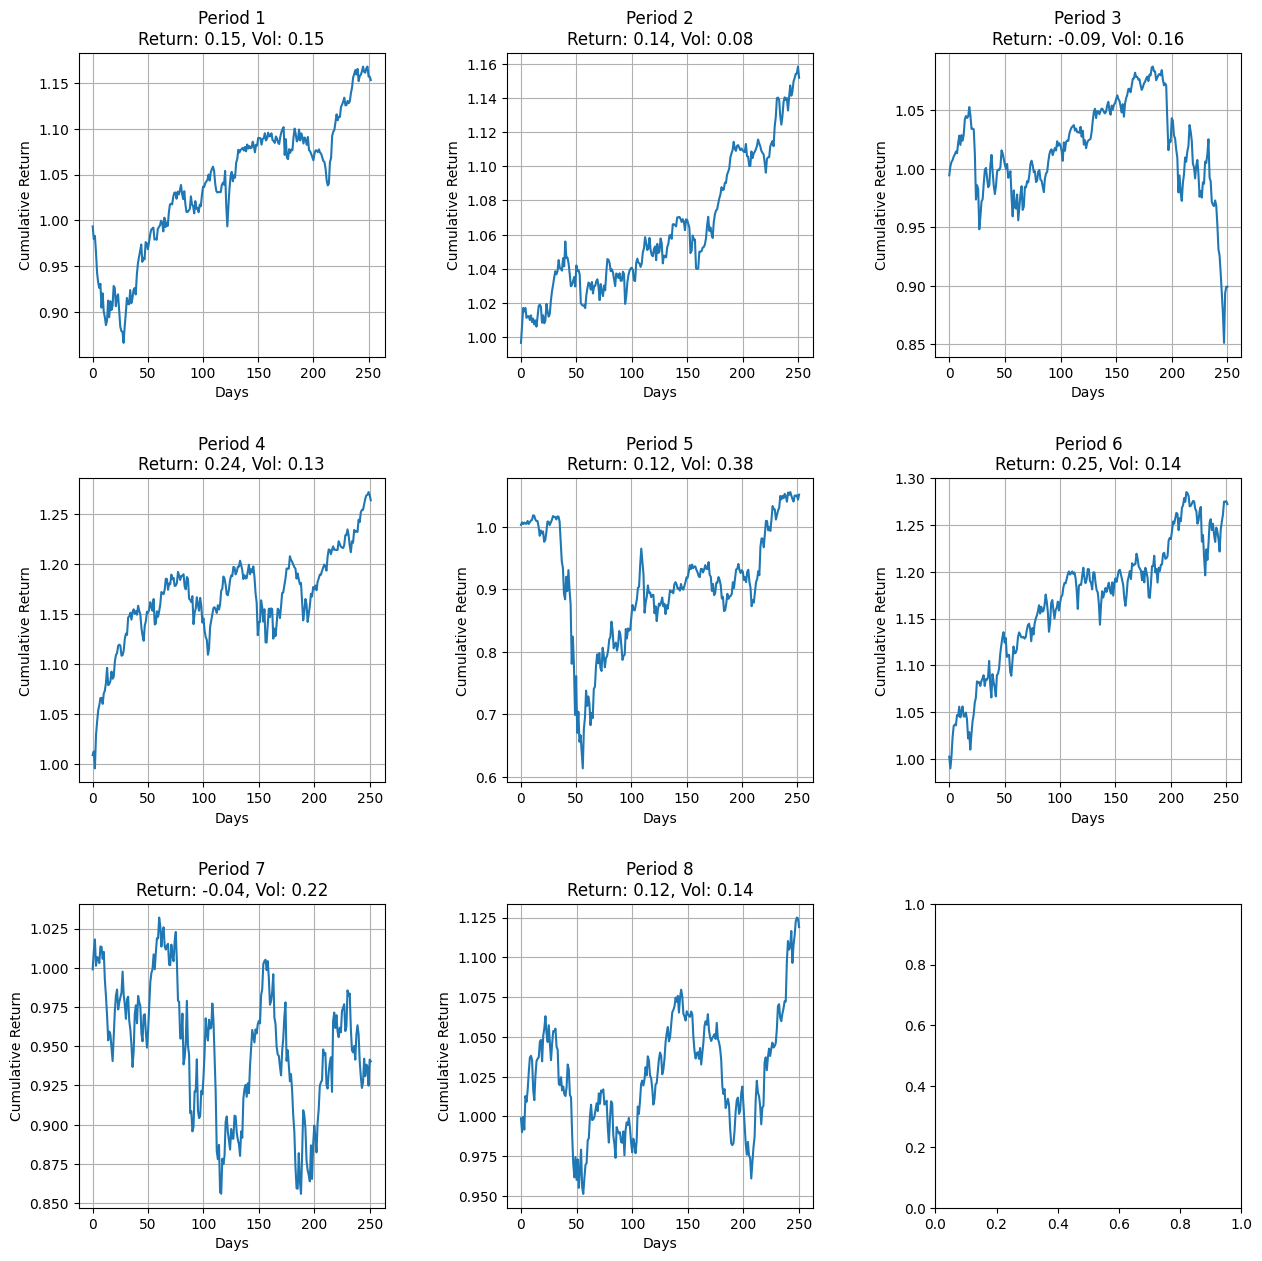

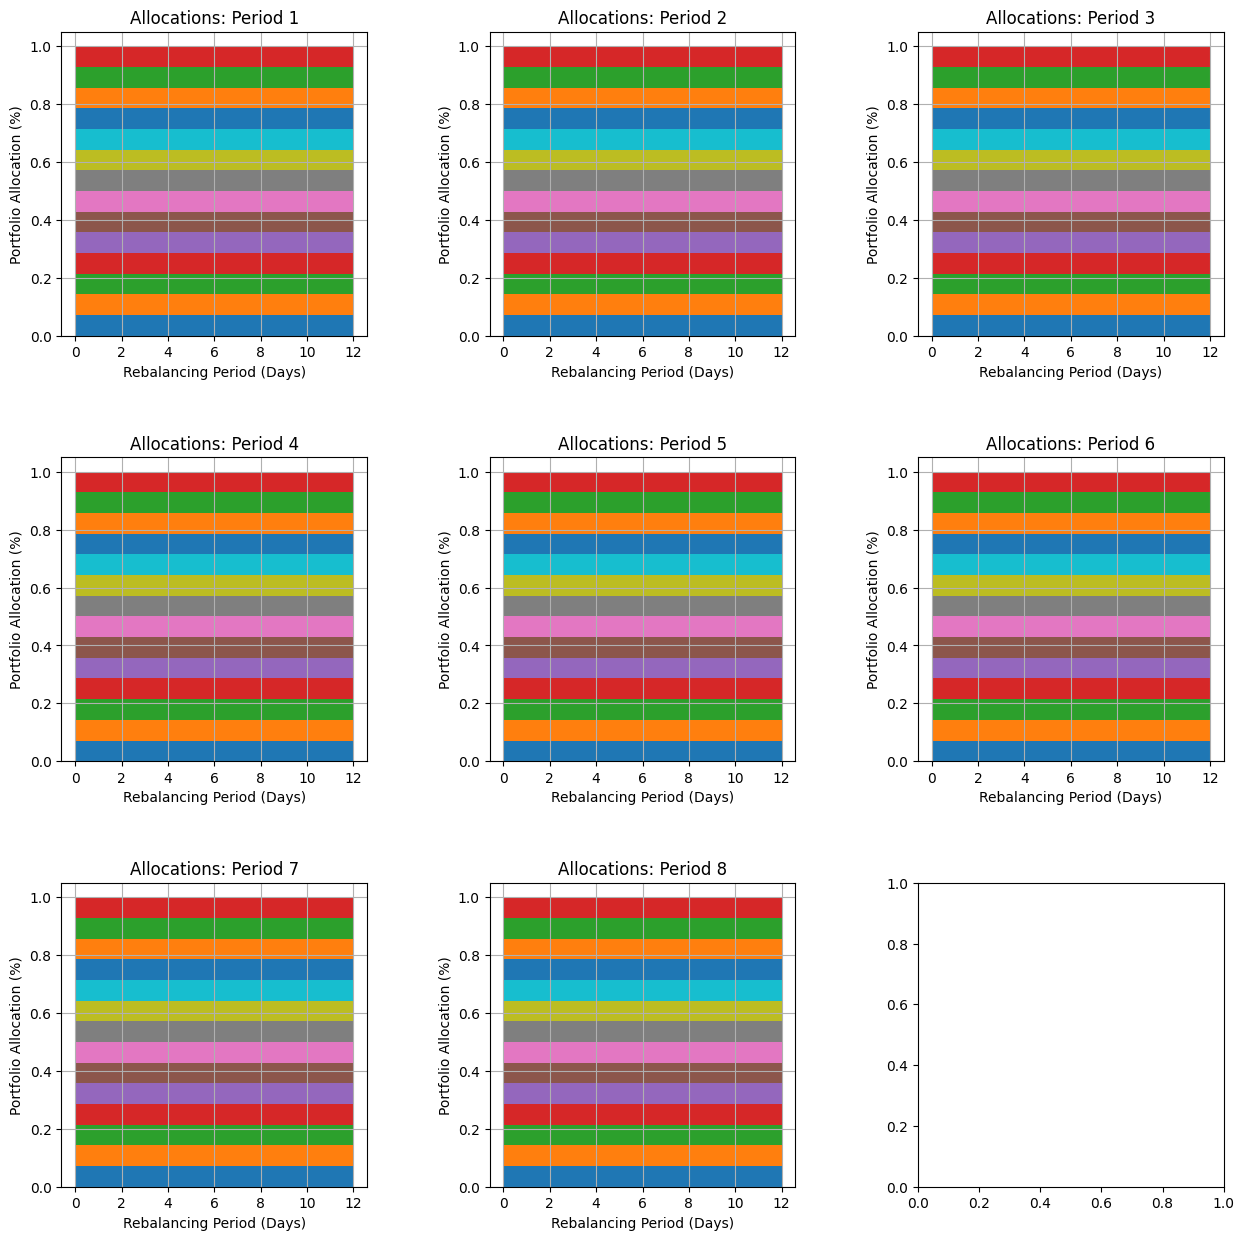


--- Portfolio Statistics for Each Period ---
Period: 1
  Annualized Return: 0.1532
  Annualized Volatility: 0.1501
  Sharpe Ratio: 1.0205
  Max Drawdown: 0.1278
  Calmar Ratio: 1.1988
--------------------------------------------------
Period: 2
  Annualized Return: 0.1442
  Annualized Volatility: 0.0760
  Sharpe Ratio: 1.8959
  Max Drawdown: 0.0369
  Calmar Ratio: 3.9081
--------------------------------------------------
Period: 3
  Annualized Return: -0.0938
  Annualized Volatility: 0.1601
  Sharpe Ratio: -0.5856
  Max Drawdown: 0.2170
  Calmar Ratio: -0.4321
--------------------------------------------------
Period: 4
  Annualized Return: 0.2422
  Annualized Volatility: 0.1270
  Sharpe Ratio: 1.9065
  Max Drawdown: 0.0694
  Calmar Ratio: 3.4907
--------------------------------------------------
Period: 5
  Annualized Return: 0.1238
  Annualized Volatility: 0.3811
  Sharpe Ratio: 0.3247
  Max Drawdown: 0.3979
  Calmar Ratio: 0.3110
--------------------------------------------------
P

In [76]:
# Analysis and Visualization

# Define the number of trading days per year
trading_days_per_year = 252

# Initialize lists to store statistics
all_stats = []

# Initialize a figure for the 3x3 grid layout
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through each period for analysis
for idx, (period, returns) in enumerate(all_portfolio_returns.items()):
    # Skip extra axes if there are fewer periods than 9
    if idx >= 9:
        break

    # Calculate cumulative returns
    cumulative_return = np.cumprod(1 + returns)

    # Calculate annualized return
    annualized_return = np.mean(returns) * trading_days_per_year

    # Calculate annualized volatility
    annualized_volatility = np.std(returns) * np.sqrt(trading_days_per_year)

    # Calculate Sharpe ratio (assuming a risk-free rate of 0 for simplicity)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

    # Calculate the max drawdown
    max_drawdown = calculate_max_drawdown(returns)

    # Calculate Calmar ratio (handle divide by zero)
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.nan

    # Store stats in a list
    all_stats.append({
        "Period": period,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    })

    # Plot cumulative portfolio returns in the top row
    axes[idx].plot(cumulative_return)
    axes[idx].set_title(f"Period {period}\nReturn: {annualized_return:.2f}, Vol: {annualized_volatility:.2f}")
    axes[idx].set_xlabel("Days")
    axes[idx].set_ylabel("Cumulative Return")
    axes[idx].grid()

# Create a new figure for stacked area plots
fig_alloc, axes_alloc = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
fig_alloc.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots

# Flatten axes array for easy indexing
axes_alloc = axes_alloc.flatten()

# Loop through each period for allocation plots
for idx, (period, weight_history) in enumerate(all_weight_history.items()):
    # Skip extra axes if there are fewer periods than 9
    if idx >= 9:
        break

    num_rebalancing_periods, num_assets = weight_history.shape

    # Stacked area plot for portfolio allocations
    axes_alloc[idx].stackplot(range(num_rebalancing_periods), weight_history.T)
    axes_alloc[idx].set_title(f"Allocations: Period {period}")
    axes_alloc[idx].set_xlabel("Rebalancing Period (Days)")
    axes_alloc[idx].set_ylabel("Portfolio Allocation (%)")
    axes_alloc[idx].grid()

# Show both figures
plt.show()

# Print all statistics
print("\n--- Portfolio Statistics for Each Period ---")
for stats in all_stats:
    print(f"Period: {stats['Period']}")
    print(f"  Annualized Return: {stats['Annualized Return']:.4f}")
    print(f"  Annualized Volatility: {stats['Annualized Volatility']:.4f}")
    print(f"  Sharpe Ratio: {stats['Sharpe Ratio']:.4f}")
    print(f"  Max Drawdown: {stats['Max Drawdown']:.4f}")
    print(f"  Calmar Ratio: {stats['Calmar Ratio']:.4f}")
    print("-" * 50)
